# **Part 1**

## **Step 1**
Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

### **Data loading and initial data inspection**

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Load the data
train_df = pd.read_csv('BBC News Train.csv')
test_df = pd.read_csv('BBC News Test.csv')

# Display the first few rows
print(train_df.head())

# Check for missing values
print(train_df.isnull().sum())

# Basic statistics: Number of articles per category
print(train_df['Category'].value_counts())
print(train_df.columns)


   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
ArticleId    0
Text         0
Category     0
dtype: int64
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64
Index(['ArticleId', 'Text', 'Category'], dtype='object')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanmarino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanmarino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Visualization

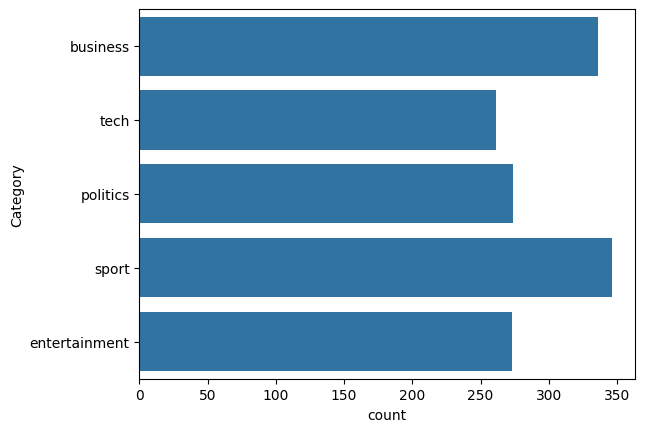

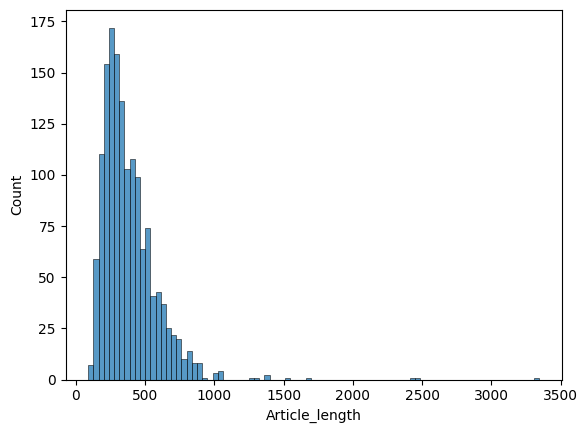

In [23]:
# Category Distribution
sns.countplot(y=train_df['Category'])
plt.show()

# Article Length Distribution
train_df['Article_length'] = train_df['Text'].apply(lambda x: len(x.split()))
sns.histplot(train_df['Article_length'])
plt.show()


### Data Cleaning

In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize, convert words to their root form. For instance, "running" becomes "run".
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

train_df['Cleaned_Article'] = train_df['Text'].apply(preprocess_text)
print(train_df['Cleaned_Article'].head())


0    worldcom exboss launch defence lawyer defendin...
1    german business confidence slide german busine...
2    bbc poll indicates economic gloom citizen majo...
3    lifestyle governs mobile choice faster better ...
4    enron boss payout eighteen former enron direct...
Name: Cleaned_Article, dtype: object


### Word Embedding
For this problem we will use TF-IDF (Term Frequency-Inverse Document Frequency).

- TF (Term Frequency): It measures how frequently a term occurs in a document.

- IDF (Inverse Document Frequency): It measures how important a term is. While computing TF, all terms are considered equally important. However, certain terms, such as "is" or "and", may appear many times but have little importance. Thus we need to weigh down the frequent terms while scaling up the rare ones.


In [25]:
vectorizer = TfidfVectorizer(max_features=5000) # Limit to top 5000 words for simplicity
X_train = vectorizer.fit_transform(train_df['Cleaned_Article'])

### Word Statistic and visualizations

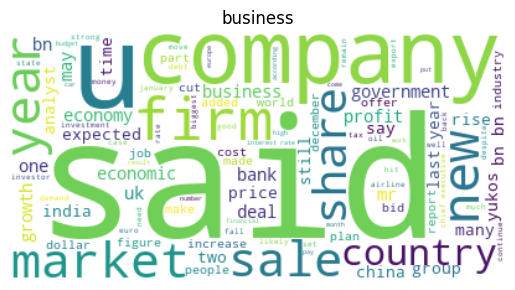

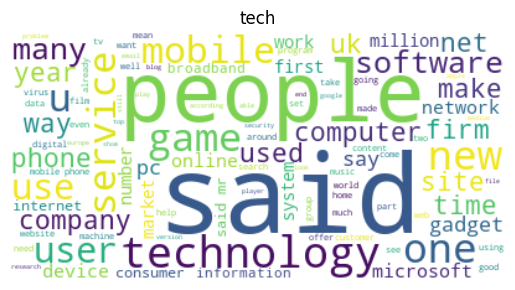

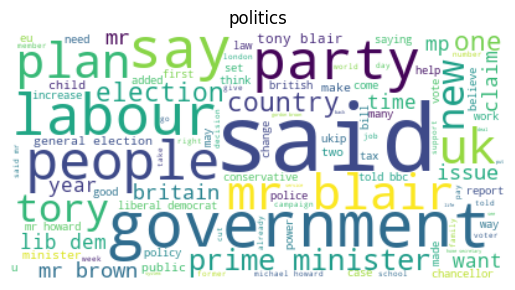

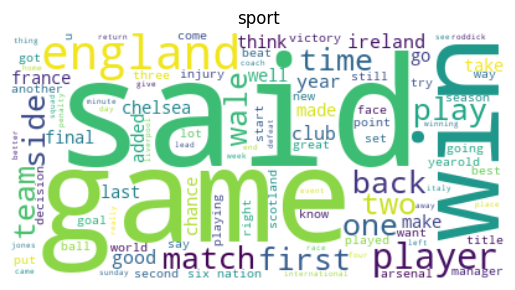

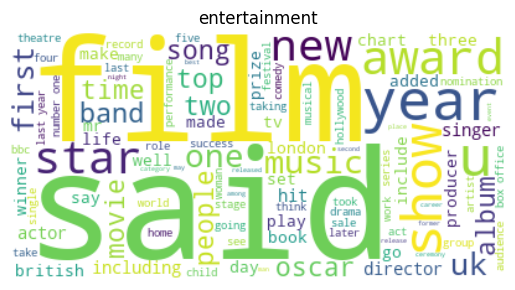

In [26]:
# Generate word cloud for each category
categories = train_df['Category'].unique()
for category in categories:
    subset = train_df[train_df['Category'] == category]
    text = ' '.join(subset['Cleaned_Article'])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category)
    plt.axis('off')
    plt.show()
